# Finding Donors for CharityML <a class="tocSkip">
## Evaluating classifiers in `scikit-learn` <a class="tocSkip">
---

## Motivation

### Economic or Business question

The goal of the project is to build a tool that predicts whether an individual makes more than \$50,000 per year. This sort of task can arise in a non-profit setting, where organizations survive on donations and have limited resources for fund-raising. Estimating people's income can help the non-profit make their fund-raising more cost-effective; for example, deciding whether to reach out at all to a potential donor. 

### Data Science motivation 

In this project I use several supervised algorithms included in the `scikit-learn` package to model person-level income using data collected from the 1994 U.S. Census. First, I obtain preliminary results from a set of algorithms. Second, I choose the best candidate algorithm and further optimize it to best model the data. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The dataset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data here incorporates small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

---
## Import Python tools and data

In [1]:
# Import libraries necessary for this project
import sys 
import numpy as np
import pandas as pd
from time import time
from IPython.display import display

# Import supplementary code: visuals.py
import visuals as vs
# Autoreload 'visuals' when changes are made
%load_ext autoreload
%autoreload 1
%aimport visuals

# Pretty display for Jupyter notebooks
%matplotlib inline

# Print Python version for future reference
print(sys.version)

3.7.1 (default, Oct 23 2018, 14:07:42) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### Load dataset

In [2]:
# Load the Census dataset
data = pd.read_csv("census.csv")

---
## Understanding the 1994 Census data

The project relies on one dataset:

> `census.csv`: Extraction was done by Barry Becker from the 1994 Census database. A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)). More details [here](https://archive.ics.uci.edu/ml/datasets/Census+Income).

### Outcome

* `'income'`: >50K, <=50K. 

### Attribute information

* `'age'`: continuous.
* `'workclass'`: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* `'education'`: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* `'education-num'`: continuous. 
* `'marital-status'`: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* `'occupation'`: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* `'relationship'`: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* `'race'`: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black. 
* `'sex'`: Female, Male. 
* `'capital-gain'`: continuous. 
* `'capital-loss'`: continuous. 
* `'hours-per-week'`: continuous. 
* `'native-country'`: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

### High-level data assessment

A cursory investigation of the dataset will determine how many individuals fit into either income group. In the code cells below, I compute the following:

* The total number of records, `'n_records'`
* The number of individuals making more than \\$50,000 annually, `'n_greater_50k'`.
* The number of individuals making at most \\$50,000 annually, `'n_at_most_50k'`.
* The percentage of individuals making more than \\$50,000 annually, `'greater_percent'`.

In [3]:
# Display the first record
display(data.head(n=1))

# Print dataset shape
print("The census dataset includes \n{} attributes for {:,} individuals."\
      .format(data.shape[1], data.shape[0]))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


The census dataset includes 
14 attributes for 45,222 individuals.


In [4]:
# Total number of records
n_records = data.shape[0]

# Number of records where income is more than $50,000
n_greater_50k = len(data['income'][data['income'] == '>50K'])

# Number of records where income is at most $50,000
n_at_most_50k = len(data['income'][data['income'] == '<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

# Print the results
print("Total number of records:\n{:,}".format(n_records))
print("Individuals making more than $50,000:\n{:,}"\
      .format(n_greater_50k))
print("Individuals making at most $50,000:\n{:,}"\
      .format(n_at_most_50k))
print("Percentage of individuals making more than $50,000:\n{:3.2f}%"\
      .format(greater_percent))

Total number of records:
45,222
Individuals making more than $50,000:
11,208
Individuals making at most $50,000:
34,014
Percentage of individuals making more than $50,000:
24.78%


### Split data into outcome and features

In [5]:
# Split outcome and features
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

---
## Preprocess data for algorithms 

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured. This process is typically known as **preprocessing**. 

Fortunately, this dataset has been partially preprocessed so there are no invalid or missing entries I must deal with; however, there are some qualities about certain features that must be adjusted. The preprocessing techniques below can improve the predictive power of nearly all learning algorithms.

### Transform skewed continuous features

Algorithms can be sensitive to skewed distributions of values and can underperform if the range is not properly normalized. With the census dataset, two features fit this description: '`capital-gain'` and `'capital-loss'`.

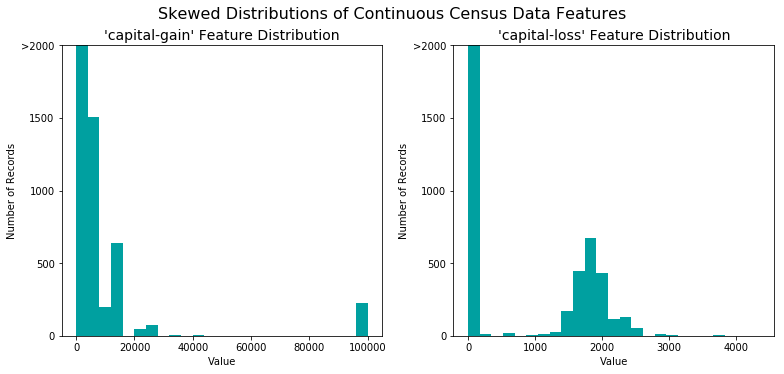

In [6]:
# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a *logarithmic transformation* on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation reduces the range of values by "pulling in" outliers.

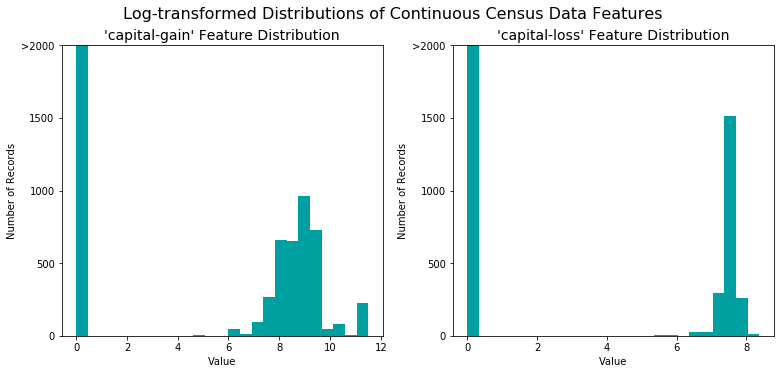

In [7]:
# Create new DataFrame for transformed data
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)

# Log-transform the skewed features
# Note: add `1` to quantities to avoid log(0)
features_log_transformed[skewed] = features_raw[skewed]\
    .apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Scale numerical features

It is often good practice to perform some type of scaling on numerical features. Scaling the data does not change the shape of each feature's distribution, in the way we saw above with `'capital-gain'` or `'capital-loss'`. However, consistent scaling ensures that each feature is treated equally by the algorithms. 

The algorithm used to scale the numerical features below is `sklearn.preprocessing.MinMaxScaler` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)).

In [8]:
# Import sklearn.preprocessing.MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Instantiate a scaler
scaler = MinMaxScaler(feature_range=(0, 1))
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 
             'hours-per-week']

# Fit scaler and store in new DF
features_minmax_transform = pd.DataFrame(data=features_log_transformed)
features_minmax_transform[numerical] = scaler.fit_transform(
    X=features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_minmax_transform.head(n = 5))

/Users/JCLH/miniconda3/envs/datascientist-nd/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning. For example, see the `'age'` data above; the original unit (i.e., years) has been lost after the transformation. 

### One-hot encode categorical features

Learning algorithms typically expect input to be numeric, which requires us to convert non-numeric, categorical features. A widely used way to convert categorical variables is by using **one-hot encoding**: which creates a *"dummy"* binary variable for each possible category of each feature.

Additionally, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

In [9]:
# One-hot encode data using pandas.get_dummies()
features_final = pd.get_dummies(features_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x == '<=50K' else 1)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("Number of features after one-hot encoding:  {}"\
      .format(len(encoded)))

Number of features after one-hot encoding:  103


### Shuffle and split data for training and testing

Here I split the data — both features and labels — into training and test sets. 80% of the data will be used for training and 20% for testing.

In [10]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {:,} samples.".format(X_train.shape[0]))
print("Testing set has {:,} samples.".format(X_test.shape[0]))

Training set has 36,177 samples.
Testing set has 9,045 samples.


----
## How to evaluate and compare a set of models

In this section, I will get preliminary results from four different algorithms — including a *naive* predictor — and will determine which is best for this tool.

### Model evaluation metrics

The underlying conceptual assumption in this application is that people who make more \\$50,000 per year are most likely to donate to their charity. Therefore, the main objective is to accurately predict this category (i.e., more than \\$50,000). Additionally, because a main objective is to maximize the cost-effectiveness of fundraising efforts, it would be detrimental to mistakenly identify someone that does not make more than \\$50,000 as someone who does. 

Looking at the distribution of the two income categories, it's clear most individuals do not make more than \\$50,000. This can substantially affect model *accuracy* and make it an inappropriate model evaluation metric. 

For classification problems that are skewed in their outcome distributions, accuracy by itself is not a sufficient metric. *Precision* and *recall* come in very handy. These two metrics can be combined to get the *F-beta score*, which is a weighted average of the precision and recall scores. 

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

### Naive predictor

> If we chose a model that always predicted an individual made more than \\$50,000, what would be that model's **accuracy** and **F-score** be on this dataset?

The purpose of generating a naive predictor like this one is to obtain the performance of a base model, without statistical learning. In a real application, the base model would be either a previously fitted algorithm or some known domain.

In [11]:
# Calculate accuracy, precision and recall
accuracy = np.sum(income) / income.count()
recall = np.sum(income) / np.sum(income)
precision = np.sum(income) / income.count() 

# Calculate F-score using beta = 0.5 
beta = 0.5
fscore = (1 + beta**2) * precision*recall / (beta**2*precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]"\
      .format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Classification models in `scikit-learn`

The following are some of the classifications algorithms that are currently available in [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html):

* Gaussian Naive Bayes (GaussianNB)
* Decision Tree Classifier
* Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
* K-Nearest Neighbors (KNeighbors)
* Stochastic Gradient Descent Classifier (SGDC)
* Support Vector Machines (SVM)
* Logistic Regression

In the sections below I choose three of these algorithms and, for each one, I address the following questions:

1. Describe an appropriate, real-world application for the model class.
2. What are the strengths of the model; when does it perform well?
3. What are the weaknesses of the model; when does it perform poorly?
4. What makes the model a good candidate for this particular tool and data?

### Logistic Regression

#### Example of application

Logistic regression is commonly applied in social science problems, where binary outcomes — e.g., "employed" vs "unempoyed" — are modeled as a function of a limited number of features; typically, giving one *independent variable* a causal interpretation. 

#### Strengths of the model

Logistic regression can be a simple, fast, and interpretable algorithm. It performs well when the features are roughly linear or when they can be transformed into a linear form. 

For research purposes, logistic regression is convenient because it can go beyond discrete classification predictions: the output can be interpreted as a vector of conditional probabilities.   

#### Weaknesses of the model

Logistic regression performs poorly when problems are not linearly separable; for example, when the outcome is associated with a nonlinear and non-monotonic function of the features. 

Also, the basic algorithm does not perform automatic feature selection.

#### Appropriateness for this project

Logistic regression is generally an appropriate, simple, and well-behaved model to start with — especially in a classification problem with two possible outcomes like this one.

**References:**
- [Quora: What are the advantages of different classification algorithms?](
https://www.quora.com/What-are-the-advantages-of-different-classification-algorithms)
- James, G., Witten, D., Hastie, T. and Tibshirani, R., 2013. An introduction to statistical learning (Vol. 112). New York: Springer.

### Decision Tree Classifier

#### Example of application

Decision Trees are commonly applied in biostatistical problems. For example, in predicting whether a health condition is present or absent based on a limited number of measurements and tests. In these cases, decision trees can be used to investigate heterogeneity in the response to some treatment by dividing the data into relevant strata; for instance, groups based on age or other segmentation of risk factors.

#### Strengths of the model

Decision Trees outperform the classic logistic regression model if there is a highly non-linear and complex relationship between the features and the response. Also, trees can be displayed graphically and are easily interpreted, especially if they are small.

#### Weaknesses of the model

Decision Trees can easily *overfit*, and generally do not have the same level of testing performance as some of the other classification approaches. Moreover, trees can be non-robust; that is, a small change in the data can cause a large change in the final estimated tree.

#### Appropriateness for this project

The feature set in this application is relatively small and contains many categorical variables, which are easily handled by Decision Trees. The resulting graphical representation of the tree can be used by the marketing practitioners and fund-raisers at the charity to make their outreach decisions. 

**References:**
- James, G., Witten, D., Hastie, T. and Tibshirani, R., 2013. An introduction to statistical learning (Vol. 112). New York: Springer.

### AdaBoost Classifier

#### Example of application

The AdaBoost Classifier can be applied to text filtering and other classification problems that are common in natural language processing.

#### Strengths of the model

AdaBoost has many practical advantages: 
* it is fast and easy to program; 
* it has few parameters to tune; 
* it requires no prior knowledge about the weak learner, so it can be flexibly combined with any method for finding weak hypotheses.

#### Weaknesses of the model

The main weakness of all boosting algorithms is plausible susceptibility to noise and outliers. 

#### Appropriateness for this project

The dataset we are working with — after the preprocessing step — is not the type of data that is generally plagued with noise and substantial outliers, so AdaBoost is a reasonable match for this application.

**References:**
- Freund, Y., Schapire, R. and Abe, N., 1999. A short introduction to boosting. Journal-Japanese Society For Artificial Intelligence, 14(771-780), p.1612.

### Creating a model evaluation pipeline

To properly evaluate the performance of each model, it's important to have a train and predict pipeline that allows quick and effective model training, using various sizes of training data, and performs predictions on the testing data.

In [12]:
# Import metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''Pipeline to train model and score predictions
    
    Args:
        learner (sklearn model): algorithm to be trained and scored
        sample_size (int): number of samples to draw from training set
        X_train (Pandas DF): features training set
        y_train (Pandas series): income training set
        X_test (Pandas DF): features testing set
        y_test (Pandas series): income testing set
       
    '''
    # Instantiate results dict
    results = dict()
    
    # Parameters for sampling training data
    train_size = X_train.shape[0]
    sample_index = np.random.RandomState(42)\
        .randint(low=0, high=train_size, size=sample_size)
    
    # Sample training data
    X_train_sampled = X_train.iloc[sample_index]
    y_train_sampled = y_train.iloc[sample_index]
    
    # Fit learner to training data
    start = time() # Get start time
    learner.fit(X=X_train_sampled, y=y_train_sampled)
    end = time() # Get end time
    
    # Calculate training time
    results['train_time'] = end - start
        
    # Get predictions 
    start = time() # start time
    # on test set (X_test)
    predictions_test = learner.predict(X_test)
    # on first 300 training samples (X_train)
    predictions_train = learner.predict(X_train_sampled.iloc[0:300])
    end = time() # end time
    
    # Calculate total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on first 300 training samples
    results['acc_train'] = accuracy_score(y_train_sampled.iloc[0:300], 
                                          predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on first 300 training samples
    results['f_train'] = fbeta_score(y_train_sampled.iloc[0:300], 
                                     predictions_train, beta=0.5)
        
    # Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print("{} trained on {} samples."\
          .format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

Test the pipeline below:

In [13]:
from sklearn.linear_model import LogisticRegression
train_predict(LogisticRegression(solver='lbfgs', random_state=42), 
              sample_size=1000, 
              X_train=X_train, y_train=y_train, 
              X_test=X_test, y_test=y_test)

LogisticRegression trained on 1000 samples.


{'train_time': 0.02977895736694336,
 'pred_time': 0.009547710418701172,
 'acc_train': 0.8333333333333334,
 'acc_test': 0.8290768380320619,
 'f_train': 0.6678700361010831,
 'f_test': 0.6534601162176439}

---
## Implementing the model evaluation pipeline

The goals of this section of the project are:

- Import the three supervised learning models discussed above.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
- Calculate and store the number of records equal to 1%, 10%, and 100% of the training data.

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


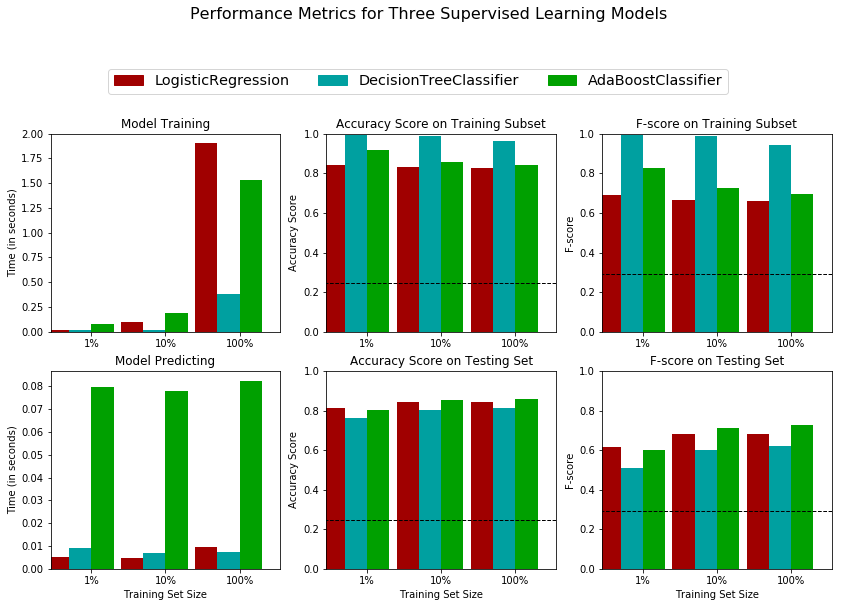

In [14]:
# Import the three classifiers 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Initialize the three models
clf_A = LogisticRegression(random_state=42, solver='newton-cg')
clf_B = DecisionTreeClassifier(random_state=42)
clf_C = AdaBoostClassifier(random_state=42)

# Calculate the number of samples for 1%, 10%, and 100% of training data
samples_100 = X_train.shape[0]
samples_10 = int(X_train.shape[0] / 10)
samples_1 = int(X_train.shape[0] / 100)

# Collect results on the learners using the pipeline: train_predict()
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three chosen classifiers 
vs.evaluate(results, accuracy, fscore)

---
## Improving model performance

In the final section, I choose a classifier to be used in this tool. 

Additionally I perform a grid-search optimization for the chosen model — tuning at least one parameter to improve upon the benchmark F-score of the model, which was calculated in the previous section.

### Choosing one of the classifiers 

Based on (1) my conceptual understanding of the model and (2) the results of the evaluation pipeline, I propose that the AdaBoost Classifier is an appropriate algorithm for the task of analyzing the census data and identifying individuals that make more than \\$50,000.

The AdaBoost Classifier trained on 100\% of the training data showed the best performance on the testing set, as measured using both accuracy score (86\%) and F-score (73\%).

Ensemble Methods like the AdaBoost Classifier require more time to train and to make predictions as compared to simpler methods like Decision Trees. That said, the training times relevant to the dimensions of data in our application are still manageable and actually shorter than the classical Logistic Regression model.

The prediction times are also substantially longer for the AdaBoostClassifier, which would be a significant problem if we needed a tool to make real-time predictions (e.g., online search and recommendation engines). In this application, the algorithm is a *backend* tool that would be used sporadically by internal analysts, so the higher prediction times should not be an important concern.

The main weakness of Boosting algorithms is their plausible susceptibility to noise and outliers, which is not a significant issue with these data, after some preprocessing.

### Describing the model in non-technical language

Boosting is an approach to machine learning based on the idea of combining many relatively weak and inaccurate rules to create highly accurate predictions. More specifically, the AdaBoost classifier is a meta-method that roughly follows this procedure:

1. begins by training a simpler model on the original training dataset; 
2. adjusts the weights of incorrectly classified instances such that a subsequent iteration of the simpler model focuses more on difficult cases;
3. trains the simpler model on the copied dataset with adjusted data weights;
4. repeats these steps a number of times, and;
5. combines the estimated parameters for the different iterations of the simpler model.

In our application, the simpler model that is trained on each iteration of the AdaBoosting classifier is a decision tree. 

Decision trees are trained by splitting each feature in the data into a number of simple value regions. For example, whether a particular individual is younger or older than 40 years old and, given that distinction, whether this individual reports a positive capital gain. This particular segmentation would split our dataset into four groups of more similar individuals as a function of our outcome of interest.  

In order to make a prediction for a given observation, we use the observed features and follow the tree branches into the correct data segment, and we classify the observation to the most commonly occurring outcome in that segment.

**References:**
- Freund, Y., Schapire, R. and Abe, N., 1999. A short introduction to boosting. Journal-Japanese Society For Artificial Intelligence, 14(771-780), p.1612.
- Schapire, R.E., 2013. Explaining adaboost. In Empirical inference (pp. 37-52). Springer, Berlin, Heidelberg.

### Fine-tuning the algorithm using `GridSearchCV`

`GridSearchCV` is a set of tools that allow us to fine-tune the parameters of an estimator. In this section I use these tools to improve the performance of the AdaBoost classifier.

In [15]:
# Import necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer

# Initialize the classifier
clf = AdaBoostClassifier(random_state=42)

# Create a dictionary of the parameters to tune
# key = parameter name, value = list of values to test
parameters = {'base_estimator':[DecisionTreeClassifier(max_depth=1), 
                                DecisionTreeClassifier(max_depth=2)],
              'n_estimators':[25, 50, 100, 200, 400]}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' 
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, 
                        scoring=scorer, cv=3)

In [16]:
# Fit grid search object to training data and find optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

In [17]:
# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized model
predictions = (clf.fit(X_train, y_train)).predict(X_test)

# Make predictions using the optimized model
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}"\
      .format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}"\
      .format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}"\
      .format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}"\
      .format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8652
Final F-score on the testing data: 0.7401


### Evaluating the optimized model

The optimized model shows a slight improvement on both accuracy (~ 1\% improvement) and F-score (~ 2\% improvement).

The optimized model is a significant improvement over the naive predictor benchmarks on both accuracy (from 25\% to 86\%) and F-score (from 29\% to 74\%).

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.8576          |      0.8652     |
| F-score        |   0.7246          |      0.7401     |

----
## Assessing the importance of attributes in the data

Before the widespread use of machine learning tools, like the ones included in scikit-learn, the selection of features to be used in the estimation of a predictive or causal inference model was mainly a manual task, which included conceptual and practical considerations. That is, the analyst would select the features in the data to be used based on their conceptual understanding of the problem as well as practical issues involving data quality. 

Here I will use scikit-learn's `feature_importances_` attribute — which is a function that ranks the importance of features according to the chosen classifier — to assess the predictive power of the different attributes in the census data. Understanding the relative importance of attributes may help in further iterations of the model; for instance, one could build a simpler and more interpretable model. 

### Guessing which attributes are important based on domain knowledge 

The most predictive features should be the ones that — holding everything else constant — more clearly separate the groups of individuals on each side of the $50k/year boundary.

**1. capital-gain:** I'd think this is the most predictive feature since most individuals showing positive a `capital-gain` are likely to be making more than $50k/year.

**2. workclass:** The categories in `workclass` seem important since I'd assume that individuals that are not working or that are woking without pay a very unlikely to be making more than $50k/year (given that we knoe their capital gain status).

**3. education:** The `education` category has been shown to be tightly associated with income. Though I'm not sure that it should be more predictive than the features above.

**4. age:** Older individuals should be more likely to be making more than $50k/year.

**5. hours-per-week:** This is a logical driver of income, but given everything else we know about these individuals I doubt that `hours-per-week` is as good a boundary as the features above. 

### Assessing the actual predictive power of features 

Let's use scikit-learn's `feature_importances_` to assess the predictive power of the different attributes in the census data in the estimation of the optimized AdaBoost classifier. 

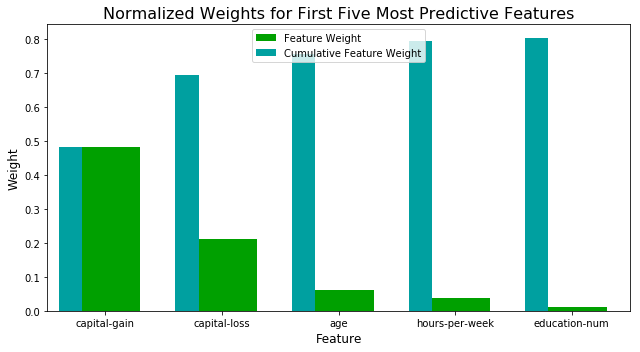

In [18]:
# Extract the feature importances
importances = best_clf.feature_importances_ 

# Plot
vs.feature_plot(importances, X_train, y_train)

### Comparing conceptual hypotheses and actual predictive power

The most predictive features are similar to the ones I discussed above, but there are relevant differences in the order. Importantly, I did not predict that `capital-loss` would be an important feature after accounting for `capital-gain`. However, `capital-loss` ended up being the second largest weight in the estimated AdaBoost model. 

The visualization above confirms that the features related to capital income are strongly associated with whether an individual makes more than \\$50k/year. Both `capital-loss` and `capital-gain` are strongly predictive. 

Features measuring the age and education of individuals are also strongly predictive, which is consistent with my hypotheses.  

### Implementing feature selection

From the visualization above, we see that the top five most important features contribute about 80\% of the importance of all features present in the data. This hints that we can attempt to reduce the *feature space* and simplify the information required for the model to learn. With less features required to train, the expectation is that training and prediction time can be much lower — at the cost of a reasonable reduction in the performance metrics. 

Below I initiate the optimized AdaBoost classifier and estimate it on the training set with only the **top 5 features in predictive importance**. 

In [19]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space to the top 5 important features
# using the output of `best_clf.feature_importances_` 
X_train_reduced = X_train[X_train.columns\
                          .values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns\
                        .values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}"\
      .format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}"\
      .format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}"\
      .format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}"\
      .format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8652
F-score on testing data: 0.7401

Final Model trained on reduced data
------
Accuracy on testing data: 0.8417
F-score on testing data: 0.7017


#### Discussion

As seen in the results printed above, testing performance decreased when using the reduced data. Accuracy went from 87% to 84%; F-score went from 74% to 70%.

The optimized model with the reduced features space (5 top attributes) performs slightly worse than both the optimized and the unoptimized models with the full feature space. 

If training and predictions times were **critical** requirements for this tool, I would consider using the reduced feature space to improve execution time at the cost of a small drop in performance. As noted above, I can see how training and prediction times would be in a critical trade-off against performance in user-interfacing applications. 

But this specific classification tool is the type of backend application where, at the expense of training and prediction times, one should use all the available features of the data which the domain experts (i.e., fundraising team) believe may be relevant for prediction performance.